In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import time
import pymc as pm
import pytensor.tensor as pt
import arviz as az
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
# === PATHS SETUP ===
SCRIPT_PATH = os.getcwd()
DATA_DIR = os.path.abspath(os.path.join(SCRIPT_PATH, '..', '..', 'data', 'preprocessed', 'analysis_data'))
MODELS_DIR = os.path.abspath(os.path.join(SCRIPT_PATH, '..', '..', 'models', 'bayesian'))
FEATURES_NAMES_DIR = os.path.abspath(os.path.join(DATA_DIR,'feature_names.pkl'))
os.makedirs(MODELS_DIR, exist_ok=True)

In [3]:
# === DATA LOADING ===
print("Loading data...")
train_path = os.path.join(DATA_DIR, 'train.csv')
test_path = os.path.join(DATA_DIR, 'test.csv')

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

target_col = 'Fault_Condition'
feature_cols = joblib.load(FEATURES_NAMES_DIR)

X_train = train_data[feature_cols]
y_train_raw = train_data[target_col]
X_test = test_data[feature_cols]
y_test_raw = test_data[target_col]

le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

print(f"Model: Bayesian Softmax Regression (PyMC)")

Loading data...
Model: Bayesian Softmax Regression (PyMC)


In [4]:
# === DATA PREPARATION FOR PYMC ===
y_map = le.classes_
n_classes = len(y_map)
n_features = X_train.shape[1]

print(f"Class mapping: {dict(enumerate(y_map))}")

Class mapping: {0: 'faulty', 1: 'faulty_zip', 2: 'healthy', 3: 'healthy_zip'}


In [5]:
# === BAYESIAN MODEL DEFINITION ===
coords = {
    "features": feature_cols,
    "classes": y_map,
    "obs_id": np.arange(len(X_train))
}

print("\nDefining probabilistic model...")
with pm.Model(coords=coords) as model:
    # --- Priors ---
    mu_w = pm.Normal("mu_w", mu=0, sigma=1)
    sigma_w = pm.HalfNormal("sigma_w", sigma=1)

    mu_b = pm.Normal("mu_b", mu=0, sigma=1)
    sigma_b = pm.HalfNormal("sigma_b", sigma=1)

    # Weights matrix [features x classes]
    W = pm.Normal("W", mu=mu_w, sigma=sigma_w, shape=(n_features, n_classes))
    # Bias vector [classes]
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, shape=(n_classes,))

    # --- Likelihood ---
    # Softmax Regression formula: X * W + b
    logits = pt.dot(X_train, W) + b

    # Categorical likelihood with Softmax probability
    y_obs = pm.Categorical(
        "y_obs",
        p=pm.math.softmax(logits, axis=1),
        observed=y_train
    )


Defining probabilistic model...


In [6]:
# === TRAINING (NUTS SAMPLING) ===
print("\nStarting NUTS sampling... This might take a while.")
start_time = time.time()

with model:
    # draws=1000: number of samples to keep
    # tune=1000: number of samples to discard (tuning step)
    # chains=4: number of independent chains
    trace = pm.sample(draws=1000, tune=1000, chains=4, target_accept=0.9, return_inferencedata=True)

elapsed_time = time.time() - start_time
print(f"Sampling finished in {elapsed_time:.2f}s")


Starting NUTS sampling... This might take a while.


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu_w, sigma_w, mu_b, sigma_b, W, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5780 seconds.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling finished in 5803.24s


In [7]:
# === DIAGNOSTICS ===
print("\nParameter Summary (Top 5):")
print(az.summary(trace, var_names=["mu_w", "sigma_w"]).head())


Parameter Summary (Top 5):
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_w    -0.025  1.142  -2.417    1.835      0.251    0.065      21.0   
sigma_w  1.214  0.310   0.697    1.811      0.020    0.010     233.0   

         ess_tail  r_hat  
mu_w         31.0   1.14  
sigma_w     541.0   1.03  


In [8]:
# === PREDICTION ON TEST SET ===
print("\nGenerating predictions for test set...")

# Using posterior means (Point Estimate) for prediction
W_mean = trace.posterior["W"].mean(dim=("chain", "draw")).values
b_mean = trace.posterior["b"].mean(dim=("chain", "draw")).values

# Calculate logits manually: X_test * W_mean + b_mean
logits_test = np.dot(X_test, W_mean) + b_mean

# Apply Softmax
exp_logits = np.exp(logits_test - np.max(logits_test, axis=1, keepdims=True))
probs_test = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

y_pred_codes = np.argmax(probs_test, axis=1)
y_pred = y_map[y_pred_codes]


Generating predictions for test set...


In [9]:
# === EVALUATION ===
test_acc = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_raw, y_pred))


Test Set Accuracy: 0.0000

Classification Report:
              precision    recall  f1-score   support

      faulty       1.00      0.86      0.92        14
  faulty_zip       0.88      1.00      0.93        14
     healthy       0.93      0.93      0.93        14
 healthy_zip       0.93      0.93      0.93        14

    accuracy                           0.93        56
   macro avg       0.93      0.93      0.93        56
weighted avg       0.93      0.93      0.93        56



<Figure size 800x600 with 0 Axes>

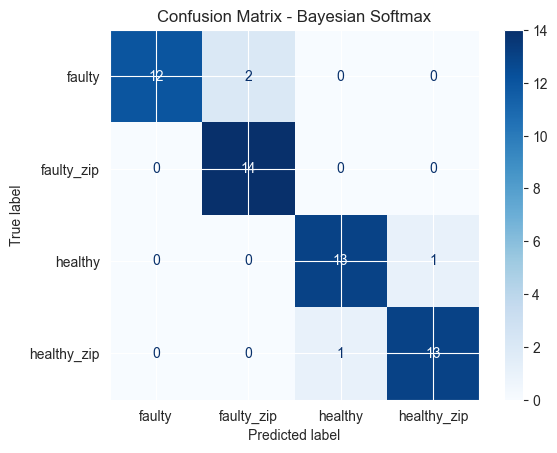

In [10]:
# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test_raw, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_map)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Bayesian Softmax")
plt.show()

array([[<Axes: title={'center': 'mu_w'}>,
        <Axes: title={'center': 'mu_w'}>],
       [<Axes: title={'center': 'sigma_w'}>,
        <Axes: title={'center': 'sigma_w'}>],
       [<Axes: title={'center': 'mu_b'}>,
        <Axes: title={'center': 'mu_b'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>]], dtype=object)

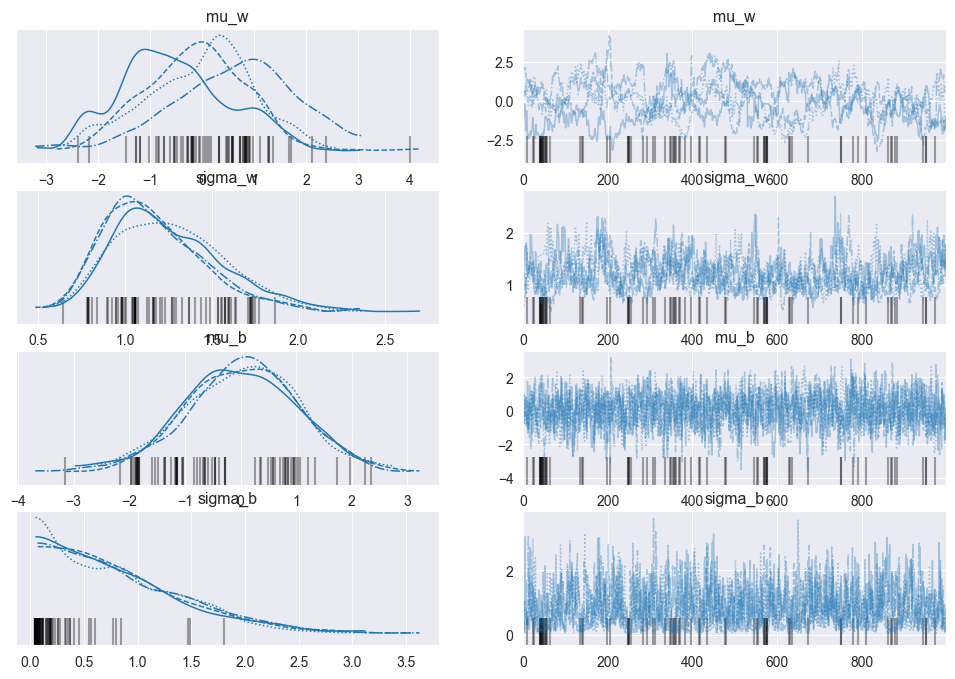

In [11]:
az.plot_trace(trace, var_names=["mu_w", "sigma_w", "mu_b", "sigma_b"])

In [13]:
# === SAVING ARTIFACTS ===
trace_path = os.path.join(MODELS_DIR, 'bayesian_trace1.nc')
trace.to_netcdf(trace_path)
print(f"\nTrace saved to: {trace_path}")

encoder_filename = 'label_encoder.pkl'
encoder_path = os.path.join(MODELS_DIR, encoder_filename)
joblib.dump(le, encoder_path)
joblib.dump(y_map, os.path.join(MODELS_DIR, 'class_map.pkl'))
print(f"Label Encoder saved to: {encoder_path}")


Trace saved to: D:\Kuba\studia\Praca_magisterska\Fault-detection-in-mechanical-devices\models\bayesian\bayesian_trace1.nc
Label Encoder saved to: D:\Kuba\studia\Praca_magisterska\Fault-detection-in-mechanical-devices\models\bayesian\label_encoder.pkl
